In [1]:
# 標準使用ライブラリー
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import shutil


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 追記
import json
import datetime
import math
plt.style.use('dark_background')

# debug
#%pdb on

import pixiedust #%pixie_debugger

# tfがエラーはかないため
#import tensorflow as tf
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


Pixiedust database opened successfully


In [2]:
##################################
#  独自ライブラリー： mshow
# (複数に対応したノートブック上画像表示)
##################################
import cv2;import numpy as np;import matplotlib as mpl;import matplotlib.pyplot as plt
%matplotlib inline
def mshow(img1, img2=None, img3=None, img4=None, img5=None):

    imgs = list(filter( lambda x: x is not None, [img1, img2, img3, img4, img5])) 
    
    
    if len(imgs) == 1:
        # 一枚のとき
        imgs[0] = imgs[0].astype(np.uint8)
        im4p = cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB)
        plt.imshow(im4p)

    else:
        # 複数枚のとき。横に並べていく
        plt.figure(figsize=(len(imgs)*4, len(imgs)*4))
        fig_exh_base = 100+len(imgs)*10
        for idx, tmp_img in enumerate(imgs):
            tmp_img = tmp_img.astype(np.uint8)
            tmp_im4p = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(fig_exh_base+idx+1)
            plt.imshow(tmp_im4p)

In [3]:
# -*- coding: utf-8 -*-
"""
Class definition of YOLO_v3 style detection model on image and video
"""

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

import sys
sys.path.append('../library/keras_yolo3/')

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

class YOLO(object):
    _defaults = {
        "model_path": 'model_data/yolo.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/coco_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        return image

    def close_session(self):
        self.sess.close()

        
    def detect_image_return_result(self, image):
        start = timer()
        
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        return out_boxes, out_scores, out_classes
        

Using TensorFlow backend.


In [4]:
def detect_img(image):

    yolo = YOLO()
    
    r_image = yolo.detect_image(image)
    print(type(r_image))
#     cv2.imwrite("out.jpg", np.asarray(r_image)[..., ::-1])
    plt.imshow(r_image)
#     yolo.close_session()


In [5]:
yolo = YOLO()

model_data/yolo.h5 model, anchors, and classes loaded.


In [6]:

image = Image.open("../images/walk.jpg")
a, b, c = yolo.detect_image_return_result(image)
print(a, b, c)


(416, 416, 3)
[[ 99.128845 493.51987  348.42532  587.34326 ]
 [ 39.38847  396.51917  354.48264  523.9533  ]
 [194.70268  134.52895  355.18503  282.98553 ]
 [244.39424  350.51917  345.22668  456.092   ]] [0.9971941  0.99459946 0.99451023 0.94219655] [ 0  0 16 16]


In [7]:
# image = Image.open("../images/walk.jpg")
# detect_img(image)

In [8]:
# !ls ../images_output

In [9]:
os.chdir("/home/input/yolov3_trial/images_output/")
# os.chdir("/home/input/yolov3_trial/images_output_bottom/")

In [10]:
import glob
l = glob.glob('./*')

image_files = sorted([os.path.basename(r) for r in l])


## 枚数を50分の1に減らす

In [11]:
results = []
for i, image_name in enumerate(image_files):
    
    if i % 200 != 25:
        continue
    
    tmp_image = Image.open(image_name)
    a, b, c = yolo.detect_image_return_result(tmp_image)
    results.append({ "objects" : a, "confidence" : b, "classes" : c})


(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)
(416, 416, 3)


In [12]:
results

[{'objects': array([[ 430.93735 ,  267.75204 ,  465.58273 ,  285.55682 ],
         [ 411.85736 , 1036.4442  ,  449.01132 , 1054.9417  ],
         [ 292.05328 ,  733.9987  ,  323.78128 ,  748.6315  ],
         [ 316.4416  ,  771.6251  ,  347.51892 ,  784.8185  ],
         [ 330.45212 ,  432.92966 ,  359.76013 ,  447.30344 ],
         [ 448.55383 ,  111.66167 ,  478.34454 ,  126.90393 ],
         [ 172.61017 , 1227.0042  ,  198.53477 , 1244.8964  ],
         [ 331.74863 ,  438.71545 ,  359.41348 ,  452.60483 ],
         [ 458.68515 ,  626.3848  ,  492.5676  ,  643.1432  ],
         [ 490.45184 ,   61.287582,  535.25586 ,   81.21866 ],
         [ 407.5373  , 1194.6825  ,  442.11084 , 1211.5134  ],
         [ 671.34564 ,  618.50836 ,  716.1362  ,  647.895   ],
         [ 642.8846  ,  650.0998  ,  687.47656 ,  668.2416  ],
         [  28.096418,  105.638504,  695.9463  , 1175.8253  ],
         [  28.096418,  105.638504,  695.9463  , 1175.8253  ]],
        dtype=float32),
  'confidence': arr

In [13]:
result_images = []

for tmp_index, tmp_frame in enumerate(results):
#     print(tmp_frame)
#     print(tmp_frame["objects"])
    tmp_index +=1
    tmp_file_name = str(tmp_index).zfill(6)+".jpg"
    im = cv2.imread( tmp_file_name )
    print(tmp_file_name)
    for tmp_index2, tmp_object in  enumerate(tmp_frame["objects"] ):
        tmp_object=list(map(int,tmp_object))
        x_from, y_from, x_to, y_to = tmp_object
        dst = im[x_from:x_to, y_from:y_to] 
#         cv2.imwrite( "../images_output_bottom_tiny_val/"+str(tmp_index).zfill(6)+"_"+str(tmp_index2).zfill(2)+".jpg", dst)
        cv2.imwrite( "../images_output_tiny_val/"+str(tmp_index).zfill(6)+"_"+str(tmp_index2).zfill(2)+".jpg", dst)
        result_images.append(dst )
        
        

000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg


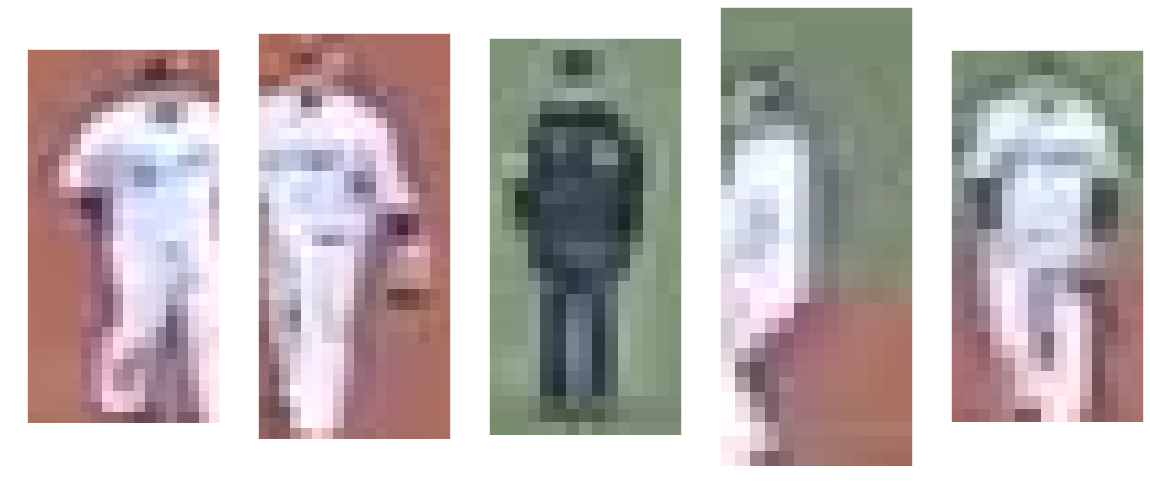

In [14]:
mshow(result_images[0], result_images[1], result_images[2], result_images[3],result_images[4])